# Chapter 5 - Exercise 8

In [1]:
using Base.Threads
using MultiThreadingTools
using Plots
pyplot();
nthreads()

56

In [2]:
x_data = collect(Float32, 0.1:0.05:0.95);
y_data = Float32[ 11.3, 19.9, 24.9, 31.1, 37.2, 36.0,  59.1,  77.2,  96.0,
          90.3, 72.2, 89.9, 91.0, 102,  109.7, 116.0, 126.6, 139.8 ];


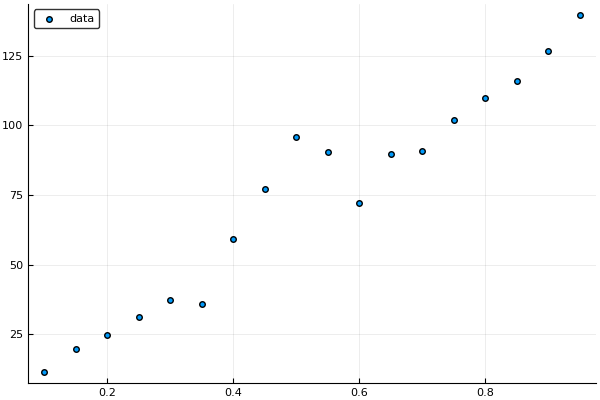

In [3]:
scatter(x_data, y_data, label="data")

In [4]:
function model_a(x::Float32, par::Array{Float32})::Float32
    r::Float32 = par[1]+par[2]*x+par[3]*x^2;
end;


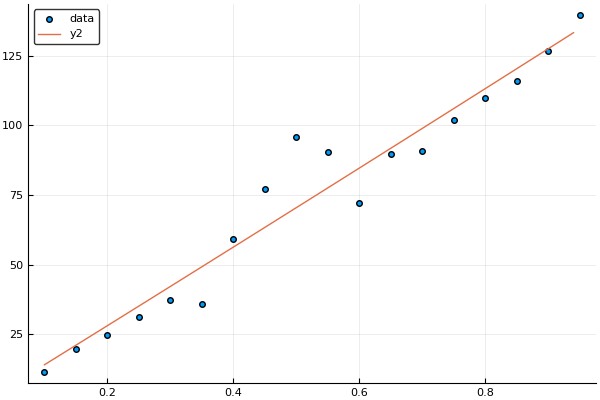

In [5]:
x_model_a = collect(Float32,x_data[1]:0.01:x_data[end])
y_model_a = [model_a(x, Float32[0., 140., 2.]) for x in x_model_a]
scatter(x_data, y_data, label="data")
plot!(x_model_a, y_model_a)

In [6]:
function normal(x::Float32, par::Array{Float32})::Float32
    r::Float32 = 1./(par[2]*sqrt(2*pi))*exp(-0.5*((x-par[1])/par[2])^2)
end;

In [7]:
function likelihood_a(a::Float32, b::Float32, c::Float32)::Float32
    llh::Float32 = 1.
    for i in 1:length(x_data::Array{Float32})
       llh *= normal(y_data[i]::Float32, [model_a(x_data[i], [a,b,c])::Float32 , Float32(4.)]) 
    end
    return llh
end;

In [8]:
function pdf_a(psA::Array{Float32}, psB::Array{Float32}, psC::Array{Float32})::Array{Float32}
    n_points_per_ps = length.([psA, psB, psC])
    pdf = zeros(Float32, (n_points_per_ps...))
    @everythread @inbounds begin
        for ia in 1:length(psA::Array{Float32})
            for ib in threadpartition(1:length(psB::Array{Float32}))
                for ic in 1:length(psC::Array{Float32})
                    @fastmath pdf[ia, ib, ic]::Float32 = likelihood_a(psA[ia],psB[ib],psC[ic])::Float32
                end
            end
        end
    end
    return pdf
end;

In [9]:
psA_a = -25:1:10
psB_a = 100:1:250
psC_a = -100:2:50

A_a = collect(Float32, psA_a)
B_a = collect(Float32, psB_a)
C_a = collect(Float32, psC_a);

In [13]:
probability_distribution_a = pdf_a(A_a, B_a, C_a);

In [10]:
function marginalize_B_C_a(pdf)
    n_points_per_ps = size(pdf)
    marg_pdf = zeros(n_points_per_ps[2:3]...)
    for ib in 1:size(pdf)[2]
        for ic in 1:size(pdf)[3]
            marg_pdf[ib, ic] = sum(pdf[:, ib, ic])
        end
    end                   
    return marg_pdf
end;    
function marginalize_A_C_a(pdf)
    n_points_per_ps = size(pdf)
    marg_pdf = zeros(n_points_per_ps[1], n_points_per_ps[3])
    for ia in 1:size(pdf)[1]
        for ic in 1:size(pdf)[3]
            marg_pdf[ia, ic] = sum(pdf[ia, :, ic])
        end
    end                   
    return marg_pdf
end;    
function marginalize_A_B_a(pdf)
    n_points_per_ps = size(pdf)
    marg_pdf = zeros(n_points_per_ps[1:2]...)
    for ia in 1:size(pdf)[1]
        for ib in 1:size(pdf)[2]
            marg_pdf[ia, ib] = sum(pdf[ia, ib, :])
        end
    end                   
    return marg_pdf
end;    

In [12]:
marged_pdf_A_a = marginalize_B_C_a(probability_distribution_a);
marged_pdf_B_a = marginalize_A_C_a(probability_distribution_a);
marged_pdf_C_a = marginalize_A_B_a(probability_distribution_a);


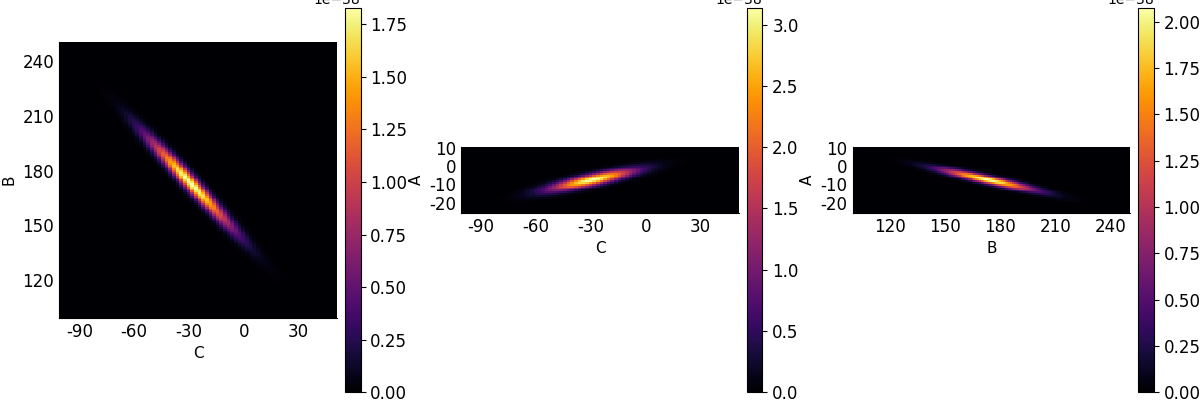

In [13]:
hA = heatmap(psC_a, psB_a, marged_pdf_A_a,aspect_ratio=1, xlabel="C", ylabel="B")
hB = heatmap(psC_a, psA_a, marged_pdf_B_a,aspect_ratio=1, xlabel="C", ylabel="A")
hC = heatmap(psB_a, psA_a, marged_pdf_C_a,aspect_ratio=1, xlabel="B", ylabel="A")
plot([hA, hB, hC]..., layout=(1,3), size=(1200,400), tickfont=12)

In [14]:
mode_a_idx = [1,1,1]
for ia in 1:length(A_a)
    for ib in 1:length(B_a)
        for ic in 1:length(C_a)
            if probability_distribution_a[mode_a_idx...] < probability_distribution_a[ia, ib,ic]
                mode_a_idx = [ia,ib,ic]
            end
        end
    end
end
println(mode_a_idx)
mode_a = [A_a[mode_a_idx[1]],B_a[mode_a_idx[2]],C_a[mode_a_idx[3]]]

[18, 78, 35]


3-element Array{Float32,1}:
  -8.0
 177.0
 -32.0


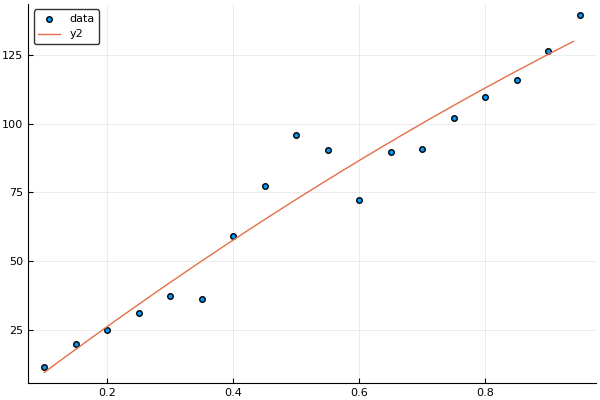

In [15]:
x_model_a = collect(Float32,x_data[1]:0.01:x_data[end])
y_model_a = [model_a(x, mode_a) for x in x_model_a]
scatter(x_data, y_data, label="data")
plot!(x_model_a, y_model_a)

In [11]:
macro marginalize(pdf, n)
    mpdf = zeros(Float64, size(eval(pdf), n))
    lod = [size(eval(pdf), dim) for dim in 1:ndims(eval(pdf))] # length of dimensions
    lofl = vcat(lod[1:n-1],lod[n+1:end])  # lofl: length of for loops
    for i in 1:length(mpdf)
        ind = ""
        for j in 1:ndims(eval(pdf))
            if j == n
                ind *= "$i,"
            else
                ind *= ":,"
            end
        end 
        ind = ind[1:end-1]
        mpdf[i] = eval(parse("sum($pdf[$ind])")) 
    end
    return mpdf
end

@marginalize (macro with 1 method)


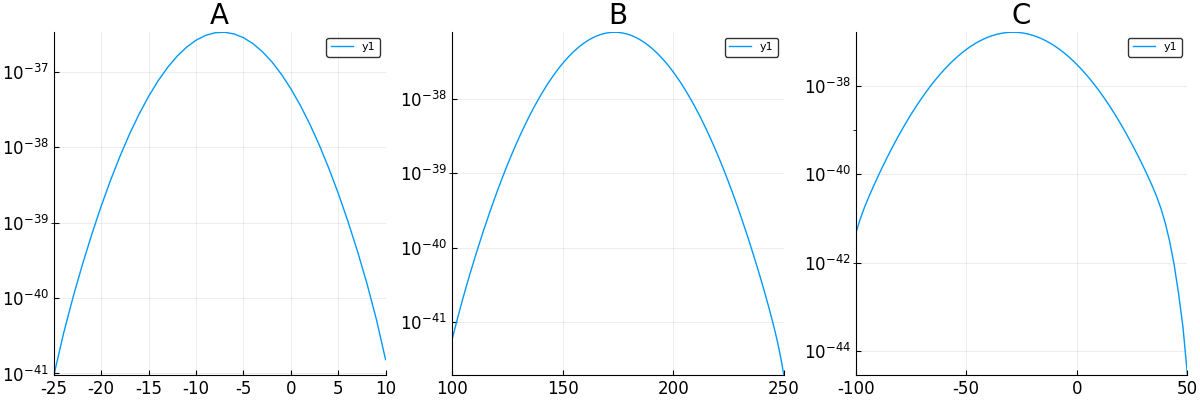

In [20]:
pdf_A_a = @marginalize probability_distribution_a 1
pdf_B_a = @marginalize probability_distribution_a 2
pdf_C_a = @marginalize probability_distribution_a 3
mA_a = plot(Float64.(A_a), pdf_A_a, title="A", titlefont=20, yscale=:log10)
mB_a = plot(B_a, pdf_B_a, title="B", titlefont=20, yscale=:log10)
mC_a = plot(C_a, pdf_C_a, title="C", titlefont=20, yscale=:log10)
plot([mA_a, mB_a, mC_a]..., layout=(1,3), size=(1200,400), tickfont=12)

# Model B

In [12]:
function model_b(x::Float32, par::Array{Float32})::Float32
    r::Float32 = par[1]+par[2]*x+par[3]*x^2+par[4]/((x-par[5])^2+par[6]^2)
end;

In [13]:
p = scatter(x_data, y_data, label="data")
x_model_b = collect(Float32,x_data[1]:0.01:x_data[end])
parameter_guess = Float32[mode_a[1], mode_a[2]*0.8, -mode_a[3]*0.2, 0.1, 0.5, 0.05]
y_model_b = [model_b(x, parameter_guess) for x in x_model_a]
plot!(x_model_b, y_model_b)

LoadError: [91mUndefVarError: mode_a not defined[39m

In [23]:
parameter_guess

6-element Array{Float32,1}:
  -8.0 
 141.6 
   6.4 
   0.1 
   0.5 
   0.05

In [14]:
function likelihood_b(par::Array{Float32})::Float32
    llh::Float32 = 1.
    for i in 1:length(x_data::Array{Float32})
       llh *= normal(y_data[i]::Float32, [model_b(x_data[i]::Float32, par), Float32(4.)]) 
    end
    return llh
end;

In [16]:
function pdf_b(psA::Array{Float32}, psB::Array{Float32}, psC::Array{Float32}, psD::Array{Float32}, psE::Array{Float32}, psF::Array{Float32})
    n_points_per_ps::Array{Int} = length.([psA, psB, psC, psD, psE, psF])
    pdf::Array{Float32} = zeros(Float32, (n_points_per_ps...))
#     println("Memory size of pdf: ",round(sizeof(pdf)/1e9,2)," GB")
    @everythread @inbounds begin
        for ia in 1:length(psA)
            for ib in threadpartition(1:length(psB))
                for ic in 1:length(psC)
                    for id in 1:length(psD)
                        for ie in 1:length(psE)
                            for i_f in 1:length(psF)
#         for i in threadpartition(CartesianRange(size(pdf)))
#              @fastmath pdf[ia,ib,ic,id,ie,i_f] = likelihood_b([psA[i[1]],psB[i[2]],psC[i[3]],psD[i[4]],psE[i[5]],psF[i[6]]])::Float32
                                @fastmath pdf[ia,ib,ic,id,ie,i_f] = likelihood_b([psA[ia],psB[ib],psC[ic],psD[id],psE[ie],psF[i_f]])::Float32
#         end
                            end
                        end
                    end
                end
            end
        end
    end
    return pdf::Array{Float32}/sum(pdf::Array{Float32})
end;

In [23]:
psA_b = -15:3:20
psB_b = 0:5:140
psC_b = -5:5:200
psD_b = 0:0.02:0.4
psE_b = 0.4:0.01:0.6
psF_b = 0.02:0.005:0.10

A_b = collect(Float32,psA_b)
B_b = collect(Float32,psB_b)
C_b = collect(Float32,psC_b)
D_b = collect(Float32,psD_b)
E_b = collect(Float32,psE_b)
F_b = collect(Float32,psF_b)

n = length(A_b)*length(B_b)*length(C_b)*length(D_b)*length(E_b)*length(F_b)*4 # n bytes
n/1e9

0.229588128

In [24]:
@time probability_distribution_b = pdf_b(A_b, B_b, C_b, D_b, E_b, F_b)

490.781830 seconds (219.35 M allocations: 5.930 GiB, 7.50% gc time)


12×29×22×21×21×17 Array{Float32,6}:
[:, :, 1, 1, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0          0.0        
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0          0.0        
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0          0.0        
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0          0.0        
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0          0.0        
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0          1.32939f-22
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     4.84834f-24  1.05796f-21
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.08818f-23  3.3669f-25 
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0          0.0        
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0          0.0        
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0          0.0        
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0          0.0        

[:, :, 2, 1, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.

In [25]:
mode_b_idx = [1,1,1,1,1,1]
mode_probability  = Float32(0)
for ia in 1:length(A_b)
    for ib in 1:length(B_b)
        for ic in 1:length(C_b)
            for id in 1:length(D_b)
                for ie in 1:length(E_b)
                    for i_f in 1:length(F_b)
                        a_prob::Float32 = probability_distribution_b[ia,ib,ic,id,ie,i_f]
                        if a_prob > mode_probability
                            mode_b_idx = [ia,ib,ic,id,ie,i_f]
                            mode_probability = a_prob
                        end
                    end
                end
            end
        end
    end
end
mode_b = Float32[A_b[mode_b_idx[1]],B_b[mode_b_idx[2]],C_b[mode_b_idx[3]],D_b[mode_b_idx[4]],E_b[mode_b_idx[5]],F_b[mode_b_idx[6]]]

6-element Array{Float32,1}:
  3.0 
 75.0 
 70.0 
  0.14
  0.49
  0.06


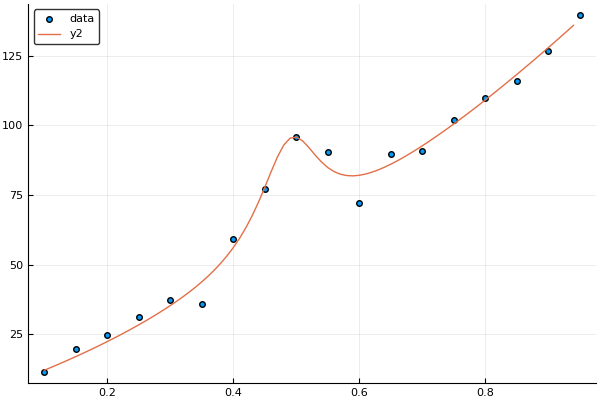

In [26]:
p = scatter(x_data, y_data, label="data")
x_model_b = collect(Float32,x_data[1]:0.01:x_data[end])
y_model_b = [model_b(x, mode_b) for x in x_model_a]
plot!(x_model_b, y_model_b)

In [27]:
mA_b = @marginalize probability_distribution_b 1
mB_b = @marginalize probability_distribution_b 2
mC_b = @marginalize probability_distribution_b 3
mD_b = @marginalize probability_distribution_b 4
mE_b = @marginalize probability_distribution_b 5
mF_b = @marginalize probability_distribution_b 6

17-element Array{Float64,1}:
 2.17005e-5 
 0.000227399
 0.000892735
 0.00250948 
 0.0112374  
 0.0358194  
 0.0805705  
 0.13378    
 0.169175   
 0.170741   
 0.14351    
 0.104126   
 0.0673735  
 0.040051   
 0.022436   
 0.0119684  
 0.00555993 


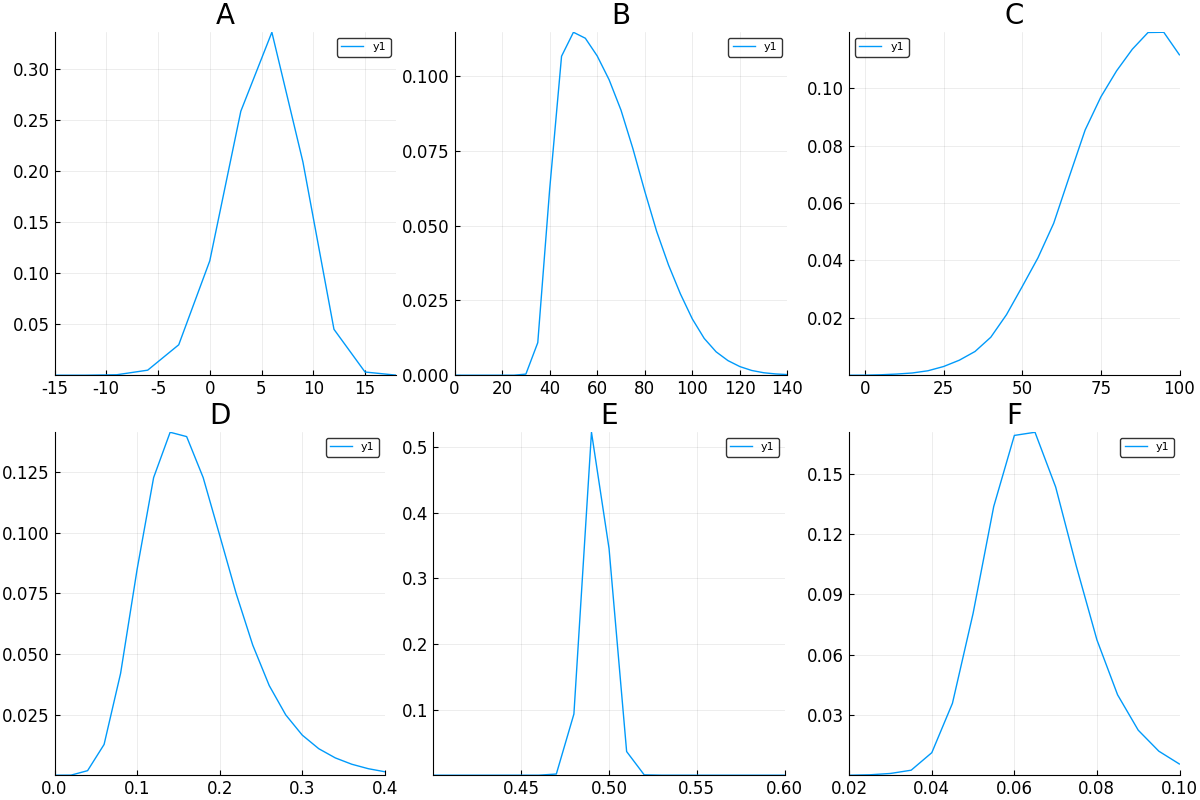

In [28]:
p1 = plot(A_b, mA_b, title="A", titlefont=20)
p2 = plot(B_b, mB_b, title="B", titlefont=20)
p3 = plot(C_b, mC_b, title="C", titlefont=20)
p4 = plot(D_b, mD_b, title="D", titlefont=20)
p5 = plot(E_b, mE_b, title="E", titlefont=20)
p6 = plot(F_b, mF_b, title="F", titlefont=20)
plot([p1,p2,p3,p4,p5,p6]..., layout=(2,3), size=(1200,800), tickfont=12)

In [29]:
psA_b = -15:3:20
psB_b = 0:5:140
psC_b = -5:5:200
psD_b = 0:0.02:0.4
psE_b = 0.4:0.01:0.6
psF_b = 0.02:0.005:0.10

A_b = collect(Float32,psA_b)
B_b = collect(Float32,psB_b)
C_b = collect(Float32,psC_b)
D_b = collect(Float32,psD_b)
E_b = collect(Float32,psE_b)
F_b = collect(Float32,psF_b)

n = length(A_b)*length(B_b)*length(C_b)*length(D_b)*length(E_b)*length(F_b)*4 # n bytes
n/1e9

0.438304608

In [ ]:
@time probability_distribution_b = pdf_b(A_b, B_b, C_b, D_b, E_b, F_b)